## 작업 배경
+ 단순히 뉴스 headline에 자주 등장하는 단어의 추출이 아닌, **뉴스들을 대표하는 의미있는 특정 주제나 토픽(이슈 or 주제 그룹)들을 자동으로 추출**해보고자 함
+ 여러 뉴스에서 담고 있는 다양한 키워드를 기반으로, 단어나 문서의 숨겨진 주제(topic)를 뽑아내어 시각화하여 제공

## 구현 알고리즘
+ **토픽 모델링(Topic Modeling)**
     - 기계 학습 및 자연어 처리 분야에서 토픽이라는 문서 집합의 추상적인 주제를 발견하기 위한 통계적 모델
     - 텍스트 본문의 숨겨진 의미 구조를 발견하기 위해 사용되는 텍스트 마이닝 기법<br><br>

+ **토픽 모델링 기법**
    + 1) 잠재 의미 분석 (Latent Semantic Analysis, LSA)
    + 2) **잠재 디리클레 할당(Latent Dirichlet Allocation, LDA)**<br><br>
        + 사전적 의미
            + Latent : 잠재적인, 숨어있는
            + Dirichlet : 19세기 독일 수학자의 이름. 디리클레 분포(Dirichlet Distribution)가 그의 이름을 따서 지어짐
            + Allocation : 할당. 각 단어를 결정할 때 θ에 대한 다항 분포(Multinomial Distribution)로 주제를 할당한 뒤 그 주제로부터 단어를 뽑는다. <br><br>

        + 설명
            + 토픽 모델링의 대표적인 알고리즘
            + **주어진 문서에 대하여 각 문서에 어떤 주제들이 존재하는 지에 대한 확률모형**
            + 결과 해석이 용이하고 과적합(Overfitting) 문제를 해결하기 때문에 방대한 비정형 데이터로부터 여러 가지 토픽(프레임)들을 도출하는데 유리함 <br><br>
           
        + 특징
            + 장점
                + 각 문서에서 단어를 가능한 적은 수의 토픽에 할당하고자 함
                + 각 토픽에 대해서는 가능한 최소의 단어에 대해 높은 확률을 부여하고자 함
                + 즉, 문서에 나타난 모든 단어를 최소한의 토픽에 할당하면서도, 할당된 단어들 중 가능한 적은 수의 단어들이 해당 토픽에 속할 확률이 높아지도록 구성 <br><br>

            + 단점
                + 토픽의 수 제한되어, 토픽 수를 잘 정밀하게 지정해야 함
                + 하나의 문서에 다양한 주제의 내용을 혼용하여 사용하는 경우에, 토픽이 서로 겹칠 수 있음<br><br>
                
         * 토픽(Topic)
             + 함께 등장할 확률이 높고, 유사한 의미를 가지는 단어들의 집합
             + 텍스트 데이터 내 단어들의 빈도를 통계적으로 분석하여 전체 데이터를 관통하는 잠재적 주제

### 1. 데이터 로드, 전처리 하기

+ 기간 : 2021.01 ~ 04
+ 건수 : 18,472건
+ 전처리 : 명사 추출

In [2]:
import pandas as pd

df_data = pd.read_excel('C:/Users/09368/workspace/data/excel/Article_economy_202101_202104.xlsx')

print(len(df_data))

title  = df_data['title'].values.tolist()
body   = df_data['body'].values.tolist()
date   = df_data['date'].values.tolist()
source = df_data['source'].values.tolist()

18472


In [3]:
from konlpy.tag import Kkma
import re
from string import punctuation
import time
import datetime

start = time.time()
kkma  = Kkma()

dataset = []

test_title = title[:1000]

# 구두점 제거
def strip_puncuation(s):
    return ''.join(c for c in s if c not in punctuation)

clean_title = []
for title in test_title:
    clean = strip_puncuation(title)
    clean_title.append(clean)
    
for i in range(len(clean_title)):
    dataset.append(kkma.nouns(re.sub('[^가-힣a-zA-Z\\s]','', clean_title[i])))

# processing time
sec   = time.time()-start
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print(times)

0:01:03


#### [전처리] 토픽모델링(pyLDAvis) 시각화 이후, 다시 전처리

In [5]:
# 단어의 비중이 너무 큰 의미없는 단어 제거
clean_title2 = []
for i in range(len(clean_title)):
    clean_title2.append(re.sub('새해','',clean_title[i]))
    
clean_title3 = []
for i in range(len(clean_title)):
    clean_title3.append(re.sub('신년','',clean_title2[i]))
    
clean_title4 = []
for i in range(len(clean_title)):
    clean_title4.append(re.sub('올해','',clean_title3[i]))
    
clean_title5 = []
for i in range(len(clean_title)):
    clean_title5.append(re.sub('지난해','',clean_title4[i]))

dataset = []
for i in range(len(clean_title)):
    dataset.append(kkma.nouns(re.sub('[^가-힣a-zA-Z\\s]','', clean_title5[i])))

### 2. Corpus Dictionary 언어모델 형성
+ LDA 모델에 들어갈 객체(dictionary, corpus) 만들고 학습하기<br><br>
+ dictinary : 각 단어를 (단어id, 나온 횟수)로 바꾸는 작업
+ corpus : i번째 뉴스 headline에서 나온 단어들을 가지고 (단어id, 나온횟수)들을 저장한 list

In [16]:
from gensim import corpora, models # LDA 적용을 위한 텍스트의 벡터화
import gensim

high_score_reviews = dataset

high_score_reviews = [[y for y in x if not len(y) == 1]
                      for x in high_score_reviews]

# 데이터를 dictionary형태로 명사 리스트 만들기
dictionary = corpora.Dictionary(high_score_reviews)

# vector로 변환한 bag of words(corpus) 결과물
corpus = [dictionary.doc2bow(text) for text in high_score_reviews]

# i번째 뉴스에서 나온 단어들을 가지고 (단어id, 나온횟수)들을 저장한 list
print(corpus[5])
print(dictionary)

[(37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1)]
Dictionary(2976 unique tokens: ['규모', '모듈', '세진', '세진중공업', '수주']...)


### 3. LDA 모델 훈련

In [18]:
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel

coherence_values = []
for i in range(2, 15):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=dictionary)
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=high_score_reviews, dictionary=dictionary, topn=10)
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)
    

### 4. 토픽모델링 평가 
+ CoherenceModel 을 통한 모델 평가 및 토픽 최적화<br><br>

+ Topic Coherence
    + 주제의 일관성을 평가하는 지표 (토픽이 얼마나 의미론적으로 일관성 있는지 판단, 높을수록 의미론적 일관성 높음)<br><br>
    
    + 해당 모델이 얼마나 실제로 의미있는 결과를 내는지 확인
    + LDA 모델의 각 토픽에서 상위 단어 간의 유사도를 재검증하는 것으로 Coherence를 측정하며, 의미적으로도 각 단어들이 일치하는지를 평가함

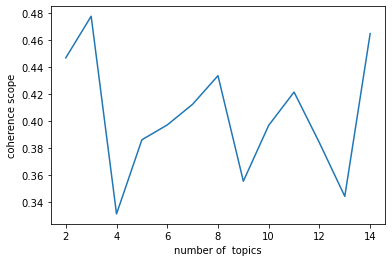

In [7]:
x = range(2, 15)

plt.plot(x, coherence_values)
plt.xlabel("number of  topics")
plt.ylabel("coherence scope")
plt.show()

In [23]:
# 각 토픽별 20개의 단어를 단어를 출력
ldamodel=gensim.models.ldamodel.LdaModel(corpus, num_topics=8, alpha=0.1, id2word=dictionary)
ldamodel.print_topics(num_words=20)

[(0,
  '0.006*"총액" + 0.006*"시가" + 0.006*"사상" + 0.006*"시가총액" + 0.006*"코스피" + 0.006*"코스" + 0.005*"아파트" + 0.005*"지원" + 0.004*"집값" + 0.004*"금융" + 0.004*"코로나" + 0.003*"경기" + 0.003*"신규" + 0.003*"개미" + 0.003*"최대" + 0.003*"회장" + 0.003*"병원성" + 0.003*"삼성" + 0.003*"최초" + 0.003*"만원"'),
 (1,
  '0.014*"코로나" + 0.012*"수출" + 0.009*"시장" + 0.008*"경제" + 0.007*"최고" + 0.007*"성장" + 0.006*"작년" + 0.005*"산업" + 0.005*"삼성" + 0.005*"개월" + 0.005*"현장" + 0.004*"최악" + 0.004*"증가" + 0.004*"장관" + 0.004*"한국" + 0.004*"체감경기" + 0.004*"상공인" + 0.004*"소상공인전통시장" + 0.004*"전통" + 0.004*"체감"'),
 (2,
  '0.019*"수출" + 0.011*"달러" + 0.009*"연간" + 0.009*"작년" + 0.007*"지원" + 0.006*"장관" + 0.006*"증가" + 0.006*"감소" + 0.005*"일자리" + 0.005*"현대" + 0.005*"전년" + 0.004*"경제" + 0.004*"한국" + 0.004*"할인" + 0.004*"백신" + 0.004*"강화" + 0.004*"최대" + 0.004*"현대차" + 0.004*"필요" + 0.004*"코로나"'),
 (3,
  '0.015*"수출" + 0.011*"코로나" + 0.008*"증가" + 0.007*"화물" + 0.006*"아시아" + 0.006*"항공" + 0.006*"최대" + 0.005*"역대" + 0.005*"기업가" + 0.005*"회장" + 0.005*"연금" + 0.005*"인상" + 0.005*"

###  5. LDA 시각화

In [11]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)

pyLDAvis.save_html(vis, 'lda.html')
# export html file

vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.111624 -0.098260       1        1  17.026552
0      0.067374  0.083779       2        1  16.718904
6     -0.133856 -0.035978       3        1  12.811491
4      0.050344 -0.004625       4        1  11.726127
2     -0.009745 -0.064403       5        1  11.079035
7     -0.052613 -0.057628       6        1  10.770101
1      0.016112  0.088781       7        1  10.519557
5     -0.049239  0.088334       8        1   9.348233, topic_info=     Term        Freq       Total Category  logprob  loglift
66     수출  102.000000  102.000000  Default  30.0000  30.0000
653    사상   26.000000   26.000000  Default  29.0000  29.0000
747   기업가   20.000000   20.000000  Default  28.0000  28.0000
754    태원   25.000000   25.000000  Default  27.0000  27.0000
753    정신   20.000000   20.000000  Default  26.0000  26.0000
...   ...         ...         ...      ...      ...      ...
9      달러    2.802038   30.037500   Topic8  -5.4875  -0.0021
1060   장관    2.801884   31.871145   Topic8  -5.4875  -0.0614
14     한국    2.142476   16.267830   Topic8  -5.7558   0.3428
154    농장    2.122922   13.401493   Topic8  -5.7650   0.5274
871    혁신    2.122810   10.059849   Topic8  -5.7651   0.8142

[560 rows x 6 columns], token_table=      Topic      Freq Term
term                      
468       2  0.148195   가격
468       4  0.148195   가격
468       5  0.148195   가격
468       6  0.296390   가격
468       7  0.296390   가격
...     ...       ...  ...
43        8  0.485068  횡성군
1614      1  0.150297   흑자
1614      2  0.450891   흑자
1614      4  0.150297   흑자
1614      5  0.150297   흑자

[1153 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 7, 5, 3, 8, 2, 6])

### 시각화 결과 해석

+ 좌표 평면    : 원의 크기 (해당 토픽이 전체 글에서 차지하는 비중)
+ 각 원의 위치 : 토픽 간 확률 분포의 유사성에 따라 다차원 척도로 정한 것
    + 유사한 토픽을 근처에 배치하기 위한 확률 분포의 유사성은 젠슨-섀널 발산 지수를 계산
    + 해당 지표는 기본적으로 각 토픽에 있는 단어들의 확률 분포에 따른 위치를 보여줌<br><br>

	+ 연관성이 낮을수록, 서로 다른 시각/프레임에 의한 텍스트 내용이 존재함
	+ 동일 분면에 위치할 경우, 상대적으로 서로 유사함. 서로 겹치는 부분이 존재하는 경우, 두 토픽 사이에 혼합적인 프레임이 존재함을 알 수 있음

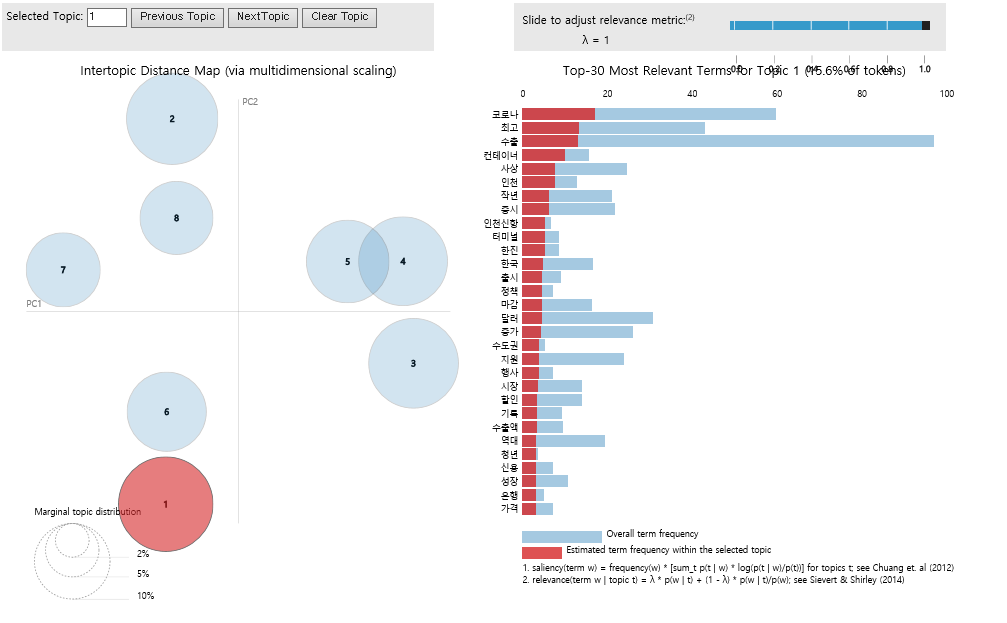

In [24]:
Image("C:/Output Image.png")

### 6. 문서별 토픽 분포 결과
+ 각 토픽에 할당된 키워드 추출(Topic-Keyword)

In [21]:
kk = ldamodel.show_topic(7, topn=8000)
type(ldamodel.show_topic)

kk2=pd.DataFrame(kk)
kk2.head(50)

,0,1
0,성장,0.008844
1,경제,0.008777
2,지원,0.008075
3,신축년,0.006482
4,한국,0.005539
5,코로나,0.005095
6,전기차,0.004891
7,부동산,0.004891
8,가격,0.004890
9,기차,0.004890


In [22]:
def make_topictable_per_doc(ldamodel, corpus, title):
    topic_table = pd.DataFrame()
    
    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)
    
        for j, (topic_num, prop_topic) in enumerate(doc):
            if j == 0:
                topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_list]), ignore_index=True)
            else:
                break

    return topic_table

topictable = make_topictable_per_doc(ldamodel, corpus, title)
topictable = topictable.reset_index()

topictable.columns = ['문서번호', '가장 비중이 높은 토픽', '가장 높은 토픽의 비중', '각 토픽의 비중']

for headline in test_title:
    topictable['뉴스 headline'] = df_data['title'][:1000]

topictable

,문서번호,가장 비중이 높은 토픽,가장 높은 토픽의 비중,각 토픽의 비중,뉴스 headline
0,0,8.0,0.9071,"[(8, 0.90713185)]",세진중공업 560억 규모 육상플랜트 모듈 수주
1,1,1.0,0.9071,"[(1, 0.90713394)]",한국조선해양 지난해 수주액 100억 달러…목표 91% 달성
2,2,2.0,0.5189,"[(0, 0.014288121), (1, 0.014288045), (2, 0.518...",“경기 하락세 1분기에는 다소 완화될 듯”
3,3,13.0,0.8839,"[(13, 0.88391817)]",울산 소상공인 81%는 ‘임차인’…보증금 네 번째 높아
4,4,8.0,0.9071,"[(8, 0.90712994)]",공영쇼핑 ‘2021 건강하소 행복하소’ 이벤트
...,...,...,...,...,...
995,995,4.0,0.5470,"[(0, 0.014288231), (1, 0.014288152), (2, 0.014...",SSG닷컴 새해 맞아 식료품 최대 68% 할인
996,996,0.0,0.8839,"[(0, 0.88391376)]",새해 맞이 쇼핑이나 해볼까…백화점 이월 상품전 50% 할인
997,997,12.0,0.8452,"[(0, 0.011906043), (1, 0.011906066), (2, 0.011...",첫 입국 환영 행사 대신…조용한 새해 맞는 항공업계
998,998,6.0,0.8839,"[(6, 0.88391787)]",코로나19 이후 기본소득 복지의 새로운 대안인가
